In [1]:
%matplotlib inline
from krazy_gridworld import KrazyGridWorld
import numpy as np
import torch
from model import Model
from utils import ReplayBuffer, get_state, sample_advice, advice_satisfied
from itertools import count
from datetime import datetime
from torch.utils.tensorboard import SummaryWriter
from matplotlib import pyplot as plt

## Hyperparameters

In [2]:
NAME='ACTRCE(-)-pretrained-3-lava' + ' ' + datetime.now().strftime('%Y-%m-%d %H:%M:%S')

max_frames = int(2e5)
save_interval = 100
train_frequency = 2
log_frequency = 1000

lr=1e-3
batch_size = 4
epsilon = 0.05
T=25

log_dir = f'/mnt/hdd1/ml/logs/{NAME}'
SAVE_DIR = 'models'

In [3]:
env = KrazyGridWorld(num_death=6)
env.reset()
channel_in, height, width = get_state(env).shape
action_dim = 4

In [4]:
if log_dir is None:
    writer = None
else:
    writer = SummaryWriter(log_dir=log_dir)
replay_buffer = ReplayBuffer()

In [5]:
net = Model(lr, height, width, channel_in, action_dim, writer=writer)

In [6]:
net.load('models', 'best')

## Utility functions

In [7]:
def epsilon_decay(frame_number, eps_init=0.01, eps_end=0.01, decay_len=100000):
    if frame_number > decay_len:
        return eps_end
    else:
        return eps_init * (1-frame_number/decay_len) + eps_end * (frame_number/decay_len)

## Training

In [8]:
success_rate_step = []
success_rate_value = []
loss_rate_step = []
loss_rate_value = []

In [9]:
frame_number = 0
success = 0
num_episodes = 0
dqn_num = 0
while frame_number < max_frames:
    env.reset(reset_agent_start_pos=True)
    advice = sample_advice()
    replay_buffer.new_episode()
    for t in range(T):
        frame_number += 1
        state = get_state(env)
        eps = epsilon_decay(frame_number)
        action = net.select_action(state, advice.split(" "), dqn_num, epsilon=eps)
            
        _, _, done, info = env.step(action)
        at_goal = env.at_goal()
        is_lava = env.is_dead()
        color = info['color']
        next_state = get_state(env)
                    
        done = done 
        satisfied = advice_satisfied(advice, color, at_goal, is_lava)
            
        replay_buffer.add(state, action, next_state, float(done), color, at_goal, is_lava)
            
        if frame_number % train_frequency == 0:
            loss = net.update(batch_size, replay_buffer, (dqn_num + 1) % 2)
            if writer is not None and loss is not None:
                writer.add_scalar("loss", loss, frame_number)
                loss_rate_step.append(frame_number)
                loss_rate_value.append(loss)
                
        if frame_number % log_frequency == 0 and writer is not None:
            writer.add_scalar('success_rate', success/num_episodes, frame_number)
            success_rate_step.append(frame_number)
            success_rate_value.append(success/num_episodes)
            success = 0
            num_episodes = 0
            
        if done or t == T - 1 or satisfied:
            replay_buffer.compute_reward(color, at_goal, is_lava)
            if satisfied:
                success += 1
            num_episodes += 1
            break    
                
    dqn_num = (dqn_num + 1) % 2

### Loss plot

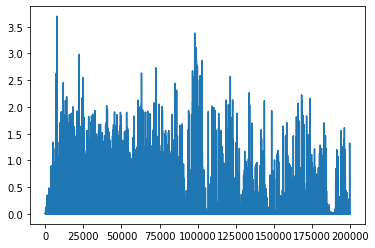

In [10]:
plt.plot(loss_rate_step, loss_rate_value)

### Success rate plot

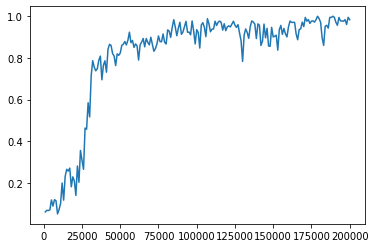

In [11]:
plt.plot(success_rate_step, success_rate_value)